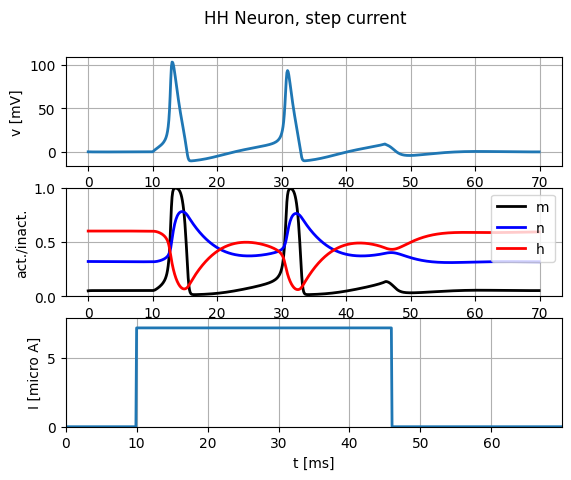

In [1]:
%matplotlib inline
import brian2 as b2
import matplotlib.pyplot as plt
import numpy as np
from neurodynex3.hodgkin_huxley import HH
from neurodynex3.tools import input_factory

HH.getting_started()

# 5.1 Exercise: step current response

## 5.1.1. Question
최소 한번 spike가 일어나는 최소 I_min 값을 찾아보아라

-> I_min을 2를 넣었을 때, v도 50mV까지밖에 증가하지 않았고, m, n, h값도 변화가 거의 없어 spike가 없다고 볼 수 있으나,<br>
-> 3을 넣었을 때는, v도 치솟고 m, n, h값도 급변하는 모습을 보여 spike가 발생했다고 볼 수 있다.

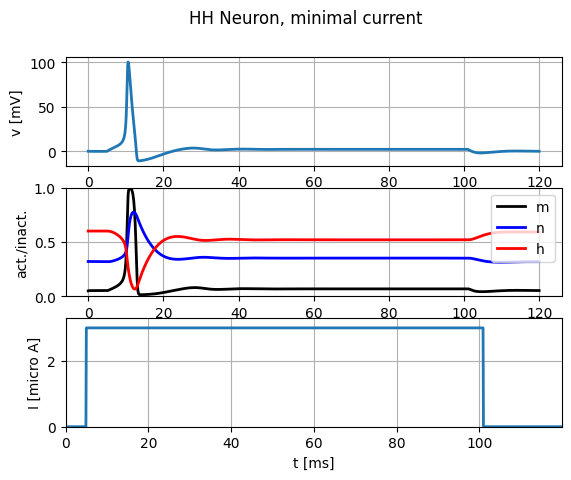

In [8]:
I_min = 3
current = input_factory.get_step_current(5, 100, b2.ms, I_min *b2.uA)
state_monitor = HH.simulate_HH_neuron(current, 120 * b2.ms)
HH.plot_data(state_monitor, title="HH Neuron, minimal current")

## 5.1.2. Question
반복되는 spike를 만드는 최소 I_min 값을 구해보아라

# 5.2. Exercise: slow and fast ramp current

## 5.2.1. Question


-> 60ms동안 I를 올리면 spike가 일어나지 않지만<br>
-> 40ms동안 I를 올리면 spike가 일어난다. (같은 I를 빠른 시간내에 주었기 때문에 spike 일어남)

Voltage slow값은 slow_ramp_t_end에서의 v값이다.

voltage_slow=0.006480498061514468


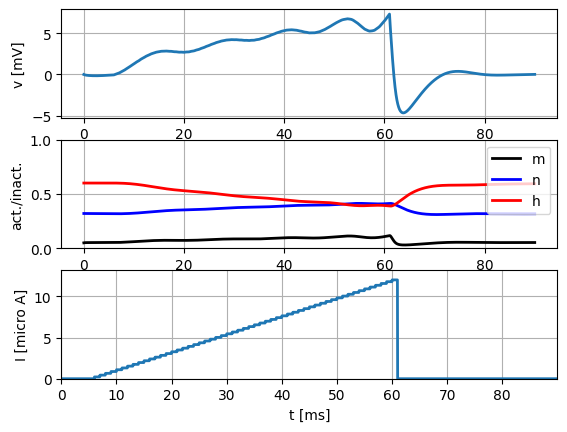

In [15]:
b2.defaultclock.dt = 0.02*b2.ms
slow_ramp_t_end = 60  # no spike. make it shorter
slow_ramp_current = input_factory.get_ramp_current(5, slow_ramp_t_end, b2.ms, 0.*b2.uA, 12.0*b2.uA)
state_monitor = HH.simulate_HH_neuron(slow_ramp_current, 90 * b2.ms)
idx_t_end = int(round(slow_ramp_t_end*b2.ms / b2.defaultclock.dt))
voltage_slow = state_monitor.vm[0,idx_t_end]
print("voltage_slow={}".format(voltage_slow))
HH.plot_data(state_monitor)

## 5.2.2. Question

-> fast 램프에서는 빠르게 증가시키면 오히려 spike X<br>
-> 전류를 주는 시간을 늘려줘야 오히려 spike가 발생한다. (80 -> 100)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
voltage_fast=0.008416848282316678


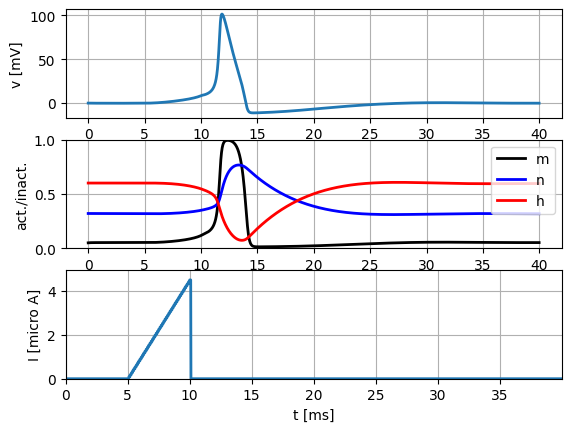

In [19]:
b2.defaultclock.dt = 0.02*b2.ms
fast_ramp_t_end = 100  # no spike. make it longer
fast_ramp_current = input_factory.get_ramp_current(50, fast_ramp_t_end, 0.1*b2.ms, 0.*b2.uA, 4.5*b2.uA)
state_monitor = HH.simulate_HH_neuron(fast_ramp_current, 40 * b2.ms)
idx_t_end = int(round(fast_ramp_t_end*0.1*b2.ms / b2.defaultclock.dt))
voltage_fast = state_monitor.vm[0,idx_t_end]
print("voltage_fast={}".format(voltage_fast))
HH.plot_data(state_monitor)

## 5.2.3. Question

5.2.2를 plot해서 viualize해라

# 5.3. Exercise: Rebound Spike

## 5.3.1. Question

step current를 -1mA와 -5mA로 각각 20ms, 50ms의 경우를 확인해보아라

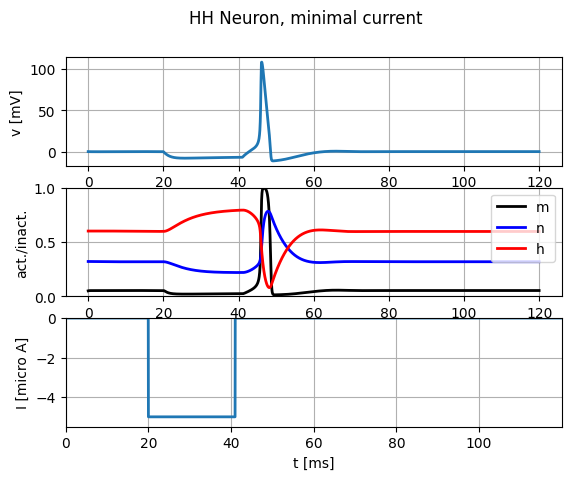

In [29]:
I_min = -5
current = input_factory.get_step_current(20, 40, b2.ms, I_min *b2.uA)
state_monitor = HH.simulate_HH_neuron(current, 120 * b2.ms)
HH.plot_data(state_monitor, title="HH Neuron, minimal current")

# 5.4. Exercise: Brian implementation of a HH neuron

## 5.4.1. Question
g_na 값을 바꾸어보아라
-> g_na값을 늘리면 더 적은 I를 부여해도 더 빠르게 spike가 튈 것이다.

g_a를 1.8배하게 되면 current가 0일 때도 repeative spike가 발생한다.

In [31]:
def simulate_HH_neuron_modify(input_current, simulation_time):

    """A Hodgkin-Huxley neuron implemented in Brian2.

    Args:
        input_current (TimedArray): Input current injected into the HH neuron
        simulation_time (float): Simulation time [seconds]

    Returns:
        StateMonitor: Brian2 StateMonitor with recorded fields
        ["vm", "I_e", "m", "n", "h"]
    """

    # neuron parameters
    El = 10.6 * b2.mV
    EK = -12 * b2.mV
    ENa = 115 * b2.mV
    gl = 0.3 * b2.msiemens
    gK = 36 * b2.msiemens
    gNa = 120 * 1.8 * b2.msiemens
    C = 1 * b2.ufarad

    # forming HH model with differential equations
    eqs = """
    I_e = input_current(t,i) : amp
    membrane_Im = I_e + gNa*m**3*h*(ENa-vm) + \
        gl*(El-vm) + gK*n**4*(EK-vm) : amp
    alphah = .07*exp(-.05*vm/mV)/ms    : Hz
    alpham = .1*(25*mV-vm)/(exp(2.5-.1*vm/mV)-1)/mV/ms : Hz
    alphan = .01*(10*mV-vm)/(exp(1-.1*vm/mV)-1)/mV/ms : Hz
    betah = 1./(1+exp(3.-.1*vm/mV))/ms : Hz
    betam = 4*exp(-.0556*vm/mV)/ms : Hz
    betan = .125*exp(-.0125*vm/mV)/ms : Hz
    dh/dt = alphah*(1-h)-betah*h : 1
    dm/dt = alpham*(1-m)-betam*m : 1
    dn/dt = alphan*(1-n)-betan*n : 1
    dvm/dt = membrane_Im/C : volt
    """

    neuron = b2.NeuronGroup(1, eqs, method="exponential_euler")

    # parameter initialization
    neuron.vm = 0
    neuron.m = 0.05
    neuron.h = 0.60
    neuron.n = 0.32

    # tracking parameters
    st_mon = b2.StateMonitor(neuron, ["vm", "I_e", "m", "n", "h"], record=True)

    # running the simulation
    hh_net = b2.Network(neuron)
    hh_net.add(st_mon)
    hh_net.run(simulation_time)

    return st_mon


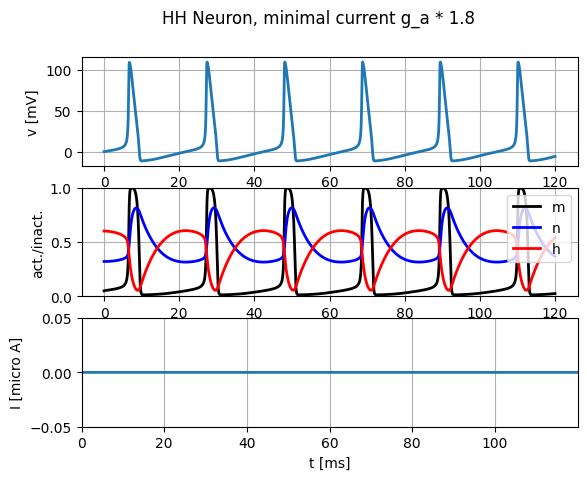

In [32]:
I_min = 0
current = input_factory.get_step_current(20, 40, b2.ms, I_min *b2.uA)
state_monitor = simulate_HH_neuron_modify(current, 120 * b2.ms)
HH.plot_data(state_monitor, title="HH Neuron, minimal current g_a * 1.8 ")